## RFM Analysis Using K-means Clustering for Customer Segmentation

#### Prepared by
##### Tiantong (Victor) Mao, Project Manager
##### Hanyue (Patrick) Yao, Data Scientist
##### UC Davis Practicum Team for Standard Insights

In [1]:
import mysql.connector

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

#### Use MySQL query to extract the data we want

In [2]:
# Establish database connection 
db = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'BDJshxbe762',
    database = 'custsegmentation'
)

In [ ]:
query_RFM = """
    -- Compute Recency, Frequency, and Monetary
    WITH LatestDateTable AS (
        SELECT MAX(OrderDate) AS LatestDate
        FROM temp_salesdata
    ), 
    DistinctOrderSums AS (
        SELECT CustomerNumber, sum(total_price) AS TotalPurchase
        FROM (
            SELECT DISTINCT *
            FROM temp_salesdata
            ) AS A
        GROUP BY CustomerNumber
        )
    SELECT 
        c.CustomerNumber, 
        MAX(s.OrderDate) AS LatestPurchase, 
        LatestDateTable.LatestDate,
        DATEDIFF(LatestDateTable.LatestDate, MAX(s.OrderDate)) AS DaysSinceLastPurchase, # recency
        count(DISTINCT OrderNumber) AS TotalNumberOfPurchase, # frequency
        DistinctOrderSums.TotalPurchase AS TotalPurchasebyCustomer # monetary
    FROM 
        customers c
    LEFT JOIN 
        temp_salesdata s ON c.customerNumber = s.CustomerNumber
    LEFT JOIN
        DistinctOrderSums ON c.customerNumber = DistinctOrderSums.CustomerNumber
    CROSS JOIN 
        LatestDateTable
    GROUP BY 
        c.customerNumber
    ORDER BY
        LatestPurchase DESC;
"""
RFM = pd.read_sql(query_RFM, con = db)
RFM

# RFM.to_csv('RFM_data.csv')

#### If we write the query in a query writer and exported the dataset, we can skip the above step and import the file manually. 

In [7]:
df = pd.read_csv('RFM_data.csv')

#### First, do some exploratory analysis on the RFM dataset

Average days since last purchase is 16.2. 


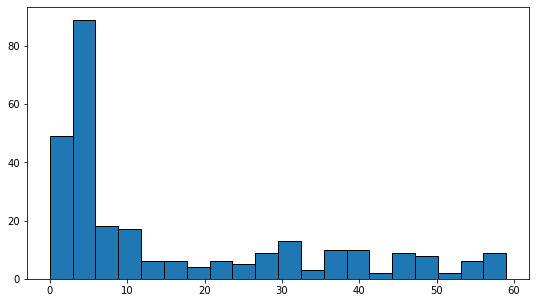

In [8]:
# Analyze Recency (R) 
plt.figure(figsize = (9, 5))
plt.hist(df['DaysSinceLastPurchase'], bins = 20, edgecolor = 'black')
print(f"Average days since last purchase is {round(np.average(df['DaysSinceLastPurchase']), 1)}. ")

In this span of two months of sales data, we have an interesting observation: a lot of customers (more than 100 out of 281) chose to purchase products within 5 days before the last date on our sales table. That is 2022-04-23. We are curious to know why. 

Average number of purchase is 1.6. 


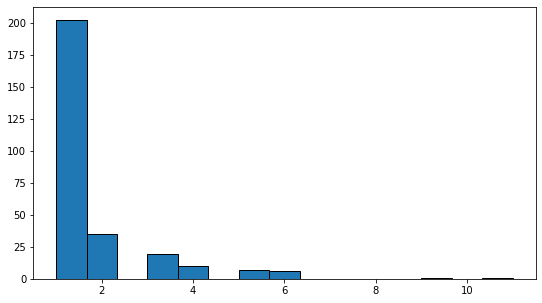

In [9]:
plt.figure(figsize = (9,5))
plt.hist(df['TotalNumberOfPurchase'], bins = 15, edgecolor = 'black')
print(f"Average number of purchase is {round(np.average(df['TotalNumberOfPurchase']), 1)}. ")

Most customers (more than 200 out of 281) purchased only once duing the span of two months. 

Average total amount purchased is $204.42. 


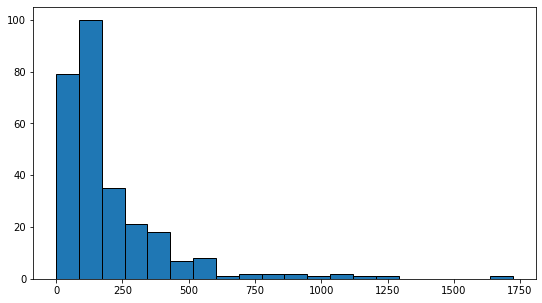

In [10]:
plt.figure(figsize = (9,5))
plt.hist(df['TotalPurchasebyCustomer'], bins = 20, edgecolor = 'black')
print(f"Average total amount purchased is ${round(np.average(df['TotalPurchasebyCustomer']), 2)}. ")

Around 2/3 customers spent less than $200. 

#### Then, conduct K-means clustering analysis on normalized data

In [11]:
from sklearn.preprocessing import StandardScaler

# Select the RFM data from the preprocessed dataset
rfm = df[['DaysSinceLastPurchase', 'TotalNumberOfPurchase', 'TotalPurchasebyCustomer']]

# Normalize the data
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm)

pd.DataFrame(rfm_normalized, columns=['Recency', 'Frequency', 'Monetary']).head()

,Recency,Frequency,Monetary
0,-0.906764,1.008782,0.279322
1,-0.906764,-0.471467,-0.471479
2,-0.906764,2.489032,2.056341
3,-0.906764,3.229157,1.179254
4,-0.906764,0.268657,0.351292


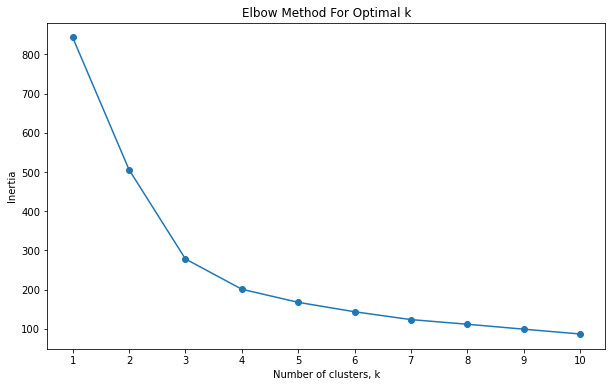

In [12]:
# Set the range of k values (number of possible cluster) from 1 to 10
k_range = range(1, 11)

# Set and store the inertias
inertias = []


for k in k_range:
  kmeans = KMeans(n_clusters=k, random_state=0)
  kmeans.fit(rfm_normalized)
  inertias.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()

The Elbow Method plot above shows how the inertia decreases as the numbers of clusters k increasing. The elbow point is where the rate of decrease in inertia becomes less steep. Thus, from the plot, a reasonable choice for k could be 3 to 5. Since there isn't a clear cut, we choose 4 as the number of clusters where the curve starts to flatten out.

In [13]:
# K-means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state = 0)
kmeans.fit(rfm_normalized)

# Assign each customer to the cluster which they belong
df['Cluster'] = kmeans.labels_
rfm['Cluster'] = kmeans.labels_

df.head()

/var/folders/z8/4r5l7fnd1mb8chrqtx2232qm0000gn/T/ipykernel_2501/3004391897.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['Cluster'] = kmeans.labels_


,Unnamed: 0,CustomerNumber,LatestPurchase,LatestDate,DaysSinceLastPurchase,TotalNumberOfPurchase,TotalPurchasebyCustomer,Cluster
0,0,4199854604447,2022-04-23,2022-04-23,0,3,266.29,3
1,1,4409300549791,2022-04-23,2022-04-23,0,1,100.00,0
2,2,5548209242271,2022-04-23,2022-04-23,0,5,659.87,1
3,3,5980700737750,2022-04-23,2022-04-23,0,6,465.61,1
4,4,6161243603158,2022-04-23,2022-04-23,0,2,282.23,3


In [14]:
# Clusters analysis
cluster_summary = rfm.groupby('Cluster').agg({
    'DaysSinceLastPurchase': 'mean',
    'TotalNumberOfPurchase': 'mean',
    'TotalPurchasebyCustomer': 'mean'
}).reset_index()

cluster_summary['Count'] = rfm['Cluster'].value_counts().sort_index()
cluster_summary.columns = ['Cluster', 'Average Recency', 'Average Frequency', 'Average Monetary', 'Customer Count']
cluster_summary.round(2)

,Cluster,Average Recency,Average Frequency,Average Monetary,Customer Count
0,0,5.08,1.05,102.88,144
1,1,7.82,5.59,864.73,17
2,2,42.47,1.24,151.79,75
3,3,11.18,2.69,367.63,45


**Cluster 0:** Customers in cluster 0 are the most recent buyers with the lowest purchase frequency and monetary value. There are 144 out of 281 of these customers. 

**Cluster 1:** Customers in cluster 1 are recent purchase , high frequency, and high monetary value. ***These customers are the most valueable segment.*** There are 17 out of 281 of these customers. 

**Cluster 2:** Customers in cluster 1 have the longest time since last purchase, wiht low frequency and low monetary value. ***These customers may be at risk of churning.*** There are 75 out of 281 of these customers. 

**Cluster 3:** Customers in cluster 3 have a recent purchase history, moderate frequency and monetary value. ***This cluster represents moderatly engaged customers.*** There are 45 out of 281 of these customers. 

#### Create visualizations

In [19]:
df.drop(['Unnamed: 0'], axis = 1)

,CustomerNumber,LatestPurchase,LatestDate,DaysSinceLastPurchase,TotalNumberOfPurchase,TotalPurchasebyCustomer,Cluster
0,4199854604447,2022-04-23,2022-04-23,0,3,266.29,3
1,4409300549791,2022-04-23,2022-04-23,0,1,100.00,0
2,5548209242271,2022-04-23,2022-04-23,0,5,659.87,1
3,5980700737750,2022-04-23,2022-04-23,0,6,465.61,1
4,6161243603158,2022-04-23,2022-04-23,0,2,282.23,3
...,...,...,...,...,...,...,...
276,5805148733599,2022-02-24,2022-04-23,58,1,55.65,2
277,4064523354271,2022-02-23,2022-04-23,59,1,101.32,2
278,5986619490518,2022-02-23,2022-04-23,59,1,58.88,2
279,5993992519894,2022-02-23,2022-04-23,59,1,51.93,2


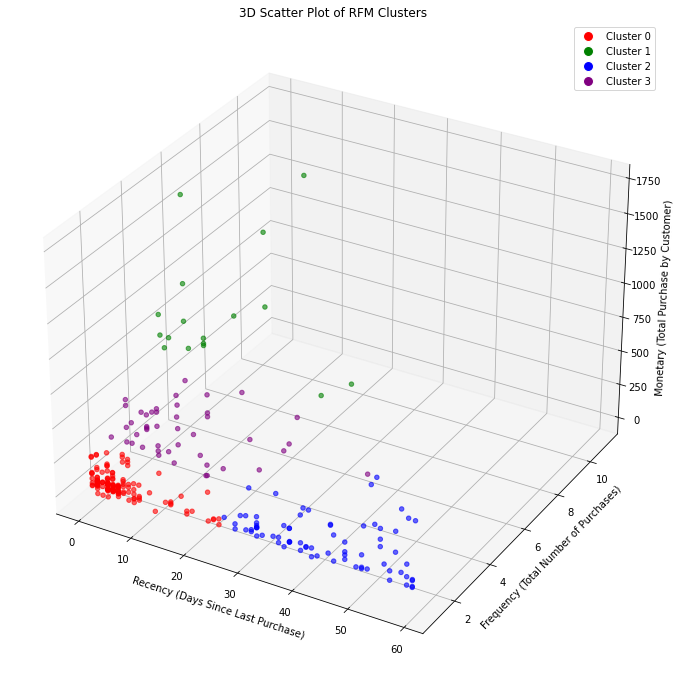

In [35]:
from mpl_toolkits.mplot3d import Axes3D

# Extract RFM and Cluster columns
recency = df['DaysSinceLastPurchase']
frequency = df['TotalNumberOfPurchase']
monetary = df['TotalPurchasebyCustomer']
clusters = df['Cluster']

# Assign colors to each cluster
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}
cluster_colors = [colors[cluster] for cluster in clusters]

# Create a figure and a 3D axis
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors
sc = ax.scatter(recency, frequency, monetary, c=cluster_colors, alpha=0.6)

# Labeling axes
ax.set_xlabel('Recency (Days Since Last Purchase)')
ax.set_ylabel('Frequency (Total Number of Purchases)')
ax.set_zlabel('Monetary (Total Purchase by Customer)')

# Title
ax.set_title('3D Scatter Plot of RFM Clusters')

# Legend - create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i),
                              markerfacecolor=mcolor, markersize=10) for i, mcolor in colors.items()]
ax.legend(handles=legend_elements, loc='upper right')

# Show plot
plt.show()

**Red: Cluster 0,** most recent buyers with the lowest purchase frequency and monetary value. There are 144 out of 281 of these customers.

**Green: Cluster 1:** recent purchase, high frequency, and high monetary value customers. ***These customers are the most valueable segment.*** There are 17 out of 281 of these customers. 

**Blue: Cluster 2:** longest number of days since last purchase, wiht low frequency and low monetary value. ***These customers may be at risk of churning.*** There are 75 out of 281 of these customers. 

**Purple: Cluster 3:** recent purchase history, moderate frequency and monetary value. ***This cluster represents moderatly engaged customers.*** There are 45 out of 281 of these customers. 